In [13]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import supervisely_lib as sly

from tqdm import tqdm
from collections import defaultdict

%matplotlib inline

In [2]:
address = 'http://192.168.1.69:5555'
token = 'YGPDnuBkhFmcQ7VNzSEjhgavjg4eFR4Eq1C3jIY4HgV3SQq2JgkXCNtgZy1Fu2ftd4IKui8DsjrdtXjB853cMtBevpSJqFDYiaG1A5qphlH6fFiYYmcVZ5fMR8dDrt5l'
team_name = 'dima'
workspace_name = 'work'

src_project_name = 'lemons_annotated'

In [3]:
api = sly.Api(address, token)

team_id = api.team.get_info_by_name(team_name)['id']
workspace_id = api.workspace.get_info_by_name(workspace_name, team_id)['id']

src_project_id = api.project.get_info_by_name(src_project_name, workspace_id)['id']

src_meta_json = api.project.get_meta(src_project_id)
src_meta = sly.ProjectMeta.from_json(src_meta_json)

In [4]:

classes_mapping = {
    'kiwi': 'kiwi',
    'lemon': 'lemon'
}
iou_threshold = 0.5

In [5]:
def compute_iou(mask_1, mask_2):
    intersection = (mask_1 * mask_2).sum()
    union = mask_1.sum() + mask_2.sum() - intersection
    if union == 0:
        return 0.0
    return intersection / union


def add_to_conf_matrix(confusion_matrix, gt_masks, gt_classes, pred_masks, pred_classes, iou_thresh):
    matches = []

    for i in range(len(gt_masks)):
        for j in range(len(pred_masks)):
            iou = compute_iou(gt_masks[i], pred_masks[j])

            if iou > iou_thresh:
                matches.append([i, j, iou])

    matches = np.array(matches)
    if matches.shape[0] > 0:
        matches = matches[matches[:, 2].argsort()[::-1][:len(matches)]]

        matches = matches[np.unique(matches[:, 1], return_index=True)[1]]

        matches = matches[matches[:, 2].argsort()[::-1][:len(matches)]]

        matches = matches[np.unique(matches[:, 0], return_index=True)[1]]

    for i in range(len(gt_masks)):
        if matches.shape[0] > 0 and matches[matches[:, 0] == i].shape[0] == 1:
            confusion_matrix[gt_classes[i] - 1][pred_classes[int(matches[matches[:, 0] == i, 1][0])] - 1] += 1
        else:
            confusion_matrix[gt_classes[i] - 1][confusion_matrix.shape[1] - 1] += 1

    for i in range(len(pred_masks)):
        if matches.shape[0] > 0 and matches[matches[:, 1] == i].shape[0] == 0:
            confusion_matrix[confusion_matrix.shape[0] - 1][pred_classes[i] - 1] += 1
            
            
def process(ann, confusion_matrix, gt_cls_map, pred_cls_map, iou_threshold):
    img_size = ann.img_size
    for cls_gt, cls_pred in classes_mapping.items():
        masks_gt, masks_pred = [], []
        classes_gt, classes_pred = [], []
        for label in ann.labels:
            if label.obj_class.name == cls_gt:
                mask = np.zeros(img_size, np.uint8)
                label.geometry.draw(mask, 1)
                masks_gt.append(mask)
                classes_gt.append(gt_cls_map[label.obj_class.name])
                
            if label.obj_class.name == cls_pred:
                mask = np.zeros(img_size, np.uint8)
                label.geometry.draw(mask, 1)
                masks_pred.append(mask)
                classes_pred.append(pred_cls_map[label.obj_class.name])
        add_to_conf_matrix(confusion_matrix, masks_gt, classes_gt, masks_pred, classes_pred, iou_threshold)

In [6]:
gt_class_mapping, pred_class_mapping = {}, {}
for i, (k, v) in enumerate(classes_mapping.items()):
    gt_class_mapping[k] = i + 1
    pred_class_mapping[v] = i + 1
confusion_matrix = np.zeros((len(classes_mapping) + 1, len(classes_mapping) + 1), dtype=np.int32)

for dataset_info in api.dataset.get_list(src_project_id):
    src_dataset_id = dataset_info['id']
    src_dataset_name = dataset_info['name']

    print('Project/Dataset: {}/{}'.format(src_project_name, src_dataset_name))
    
    for image_info in tqdm(api.image.get_list(src_dataset_id)):
        src_image_ext = image_info['meta']['mime'].split('/')[1]

        ann_json = api.annotation.download(src_dataset_id, image_info['id'])
        ann = sly.Annotation.from_json(ann_json, src_meta)
        process(ann, confusion_matrix, gt_class_mapping, pred_class_mapping, iou_threshold)

  0%|          | 0/6 [00:00<?, ?it/s]

Project/Dataset: lemons_annotated/ds1


100%|██████████| 6/6 [00:00<00:00, 13.12it/s]


In [7]:
targets_names = list(gt_class_mapping.keys())
targets_names.append('False Positives')
pred_names = list(pred_class_mapping.keys())
pred_names.append('False Negatives')
df = pd.DataFrame(confusion_matrix, columns=pred_names, index=targets_names)

In [79]:
options = dict(selector="th", props=[('text-align', 'center')])
df.style.set_properties(**{'width':'10em', 'text-align':'center'}).set_table_styles([options])

,kiwi,lemon,False Negatives
kiwi,20,0,0
lemon,0,6,0
False Positives,0,0,0


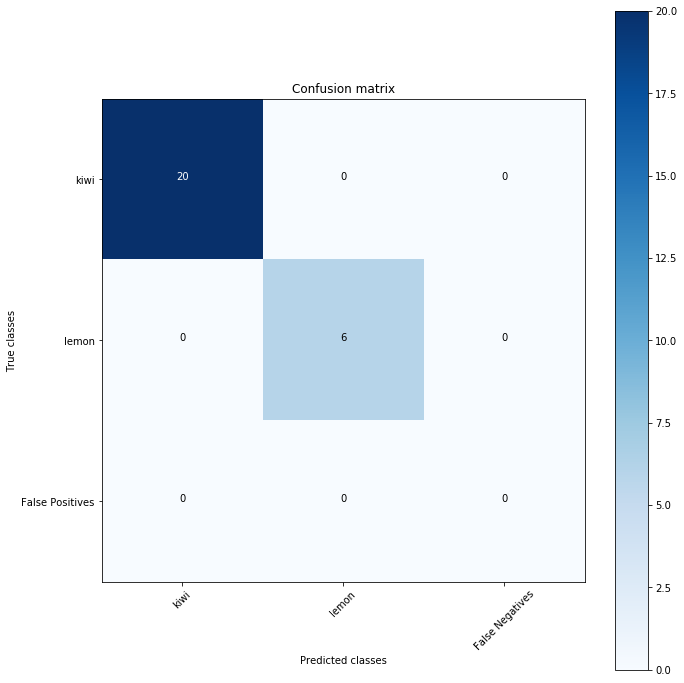

In [15]:
def plot_confusion_matrix(cm, gt_classes, pred_classes, cmap=plt.cm.Blues):
    _ = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(gt_classes))
    plt.xticks(tick_marks, pred_classes, rotation=45)
    plt.yticks(tick_marks, gt_classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True classes')
    plt.xlabel('Predicted classes')
    plt.tight_layout()
plot_confusion_matrix(confusion_matrix, targets_names, pred_names)